In [14]:
%pylab inline

import sys
import os
par_dir = os.path.split(os.getcwd())[0]
if par_dir not in sys.path:
    sys.path.append(par_dir)
# sys.path.append(r'/Users/artemgolovizin/GitHub')
from scipy.optimize import curve_fit
import inspect
import pickle
import imp
import re

from IPython.html import widgets
from IPython.display import display
from IPython.html.widgets import interact, interactive, fixed

from IPython import parallel

import thulium_python_lib.image_processing_new as impr
rc1 = parallel.Client()
lview = rc1.load_balanced_view()
dview = rc1.direct_view()
with dview.sync_imports():
    import sys, os    
dview['par_dir'] = par_dir
%px if par_dir not in sys.path: sys.path.append(par_dir)
#%px if r'/Users/artemgolovizin/GitHub' not in sys.path: sys.path.append(r'/Users/artemgolovizin/GitHub')
%px import thulium_python_lib.image_processing_new as impr
%px import imp
%px from IPython.parallel import bind_kernel; bind_kernel()

Populating the interactive namespace from numpy and matplotlib
importing sys on engine(s)
importing os on engine(s)


`%matplotlib` prevents importing * from pylab and numpy


In [ ]:
# to reload library on remote and local engine
#%px imp.reload(impr)
#imp.reload(impr)

###Helper functions

In [15]:
def exp_decay(t, N0, tau, background):
    return N0 * exp(- t / tau) + background
def exp_decay_no_bg(t, N0, tau):
    return N0 * exp(- t / tau)
def cloud_expansion(t, T, r0, t0):
    k_b = 1.38e-23
    m = 169 * 1.66e-27
    return sqrt( r0**2 + 2 * k_b * T * (t + t0)**2 / m)
def exp_grouth(t, N0, tau, background):
    return N0 * ( 1 - exp( - t / tau)) + 0*background
# function to convert arbitrary units to atoms number
convert_N_atoms = impr.N_atoms(width=0.5, delta = 5)

def feshbah_calibration(folder, data_dict):
    """gets folder name, which has 'conf=BH(SH)' to detect which coil current was scanned and 'offset=value' to calculate
    offset field (produced with another coil) 
    second parameter is data_dictionary to modify"""
    coil_dict = dict(BH=10.2, SH=0.25)
    reverse_coil_dict = dict(BH='SH', SH='BH')
    coeff = 1
    offset = 0
    for s0 in folder.rstrip(r'\/ ').split():
        if '=' in s0:
            s1 = s0.split('=')
            if s1[0] == 'conf':
                coeff = coil_dict[s1[1]]
                offset_coeff = coil_dict[reverse_coil_dict[s1[1]]]
            if s1[0] == 'offset':
                offset = float(re.findall(r"[-+]?\d*\.\d+|\d+", s1[1])[0]) * offset_coeff
    data_dict['x'] = data_dict['x'] * coeff + offset
    
def construct_fit_description(fit_func, popt_T):
    """constructs a set of string of type 'variable=value\n' for all [1:] function variables"""
    res = ''
    for item in zip(inspect.getargspec(fit_func)[0][1:], popt_T):
        res += str(item[0]) + ' = ' + "%.2f"%(item[1]) + '\n'
    res = res.rstrip('\n')
    return res

###And now:
###Constract loader and averager 
For available parameters see help('instance')

In [16]:
loader  = impr.Load_Image(dview)
averager = impr.Avr_Image(dview)

###Setting directory to work with 

####Set date of measurement directory and create folder Figures 

In [18]:
#os.chdir(r'D:\!Data\2015_07_01')
os.chdir(r'\\BIGONE\!Data\2015_07_01')
print('Current directory', os.getcwd());
# Create folder 'Figures' for saving individual plot
if not os.path.exists('Figures'):
    os.makedirs('Figures')
    print('Folder Figures has been created')
    
working_directory = ''
folder = ''

Current directory \\BIGONE\!Data\2015_07_01


####Set measurement folder 

In [20]:
dirs = [x for x in os.listdir() if re.match('\d',x)]
dirs.reverse()
@interact(folder_=dirs)
def h(folder_=folder):
    global working_directory
    global folder
    folder = folder_
    working_directory = os.path.join(os.getcwd(),folder)
    print('Working directory', working_directory)

Working directory \\BIGONE\!Data\2015_07_01\18 364.54


###Loading images  

In [21]:
# downloading images
all_data = loader(working_directory,lview)

  50/50 tasks finished after    1 s
done

Total number of images:  50


In [22]:
# rearranging to dictionary
dataD = impr.rearrange_data(all_data)

Rearranging to dictionary is complited


In [23]:
# sifting(filtering) data - removing empty images  !!! DOES NOTE WORKS NOW
#impr.sift(dataD)

In [24]:
# for plotting sifted image
#imshow(imread('1 от частоты амплитудной модуляции аома верди (5) 3.9W/26ms/2_1.png'))
#colorbar()

In [25]:
# averaging data
avr_dataD = averager(dataD,lview)

   5/5 tasks finished after    0 s
done
0 images are sifted in folder=0.000000,shot_typeN=1
0 images are sifted in folder=1.000000,shot_typeN=1
1 images are sifted in folder=2.000000,shot_typeN=1
6 images are sifted in folder=3.000000,shot_typeN=1
All images are sifted infolder=4.000000,shot_typeN=1



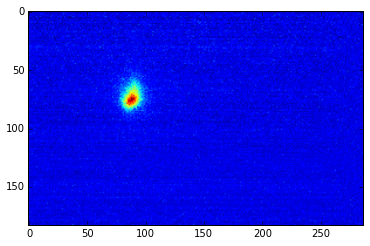

In [26]:
imshow(avr_dataD[0][1].image)

### After above, we can analize our data 

####Construct  data

In [27]:
shot_typeN = 1
# first set of data  - Temperature X
d1 = impr.get_avr_data_for_plot(avr_dataD, shot_typeN, impr.real_size, 'fit1D_x',2)
d1['fmt']='ro'
d1['label']='fit1D_x'
#impr.drop_by_number(d1,5)
#impr.drop_by_x(d1,18,20)

# second set of data  - Temperature Y
d2 = impr.get_avr_data_for_plot(avr_dataD, shot_typeN, impr.real_size, 'fit1D_y',2)
d2['fmt']='bo'
d2['label'] = 'fit1D_y'
#impr.drop_by_number(d2,5)

# third set of data - number of atoms 
d4 = impr.get_avr_data_for_plot(avr_dataD, shot_typeN, impr.real_size, 'fit1D_y',1)
d4['fmt']='bo'
d4['label']='fit1D_x'

####Fitting 

In [28]:
# fit_func - which function to use to fit data
fit_func = cloud_expansion
popt_T, pcov_T = curve_fit(fit_func, d1['x'], d1['y'], p0=(d1['y'][0],20,0))
print('Fit parameters',*list(zip(inspect.getargspec(fit_func)[0][1:], popt_T)))
popt_T2, pcov_T2 = curve_fit(fit_func, d2['x'], d2['y'], p0=(d2['y'][0], 20,0))
print('Fit parameters',*list(zip(inspect.getargspec(fit_func)[0][1:], popt_T2)))

Fit parameters ('T', 34.573652054109345) ('r0', 101.6675346226689) ('t0', 0.052094381332652602)
Fit parameters ('T', 37.211057057319536) ('r0', 118.93760302115159) ('t0', 0.40161392944626523)


C:\Program Files\Anaconda\lib\site-packages\IPython\kernel\__main__.py:8: RuntimeWarning: invalid value encountered in sqrt


###Plot data 

####Main plot (1) 

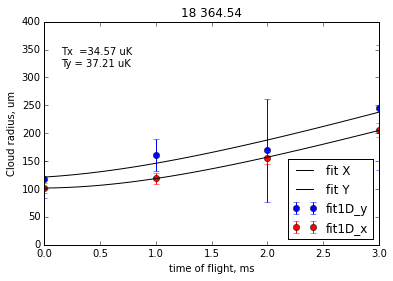

In [29]:
fig1, ax1 = subplots()
ax1.errorbar(**d2)
ax1.errorbar(**d1)

ax1.plot(linspace(min(d1['x']),max(d1['x']),100), fit_func(linspace(min(d1['x']),max(d1['x']),100),*popt_T),'k', label='fit X')
ax1.plot(linspace(min(d2['x']),max(d2['x']),100), fit_func(linspace(min(d2['x']),max(d2['x']),100),*popt_T2),'k', label='fit Y')

ax1.set_xlabel('time of flight, ms')
ax1.set_ylabel('Cloud radius, um')
ax1.set_title(folder)
ax1.set_ylim(bottom=0)
ax1.legend(loc=4)
fit_label='Tx  =%.2f uK\nTy = %.2f uK' % (popt_T[0],popt_T2[0])
ax1.text(0.05,0.8,fit_label,transform=ax1.transAxes)

In [30]:
list(zip(d1['x'],d1['y']))

[(0.0, 101.52804454930933),
 (1.0, 119.39651396220714),
 (2.0, 156.17858705236438),
 (3.0, 205.3638562716805)]


####Main plot (2)  - number of atoms 

In [31]:
def cloud_drop(t, y0, v0, g):
    return y0 + v0*t + g*t**2/2

###Cloud center

[ 814.54432963    9.07407111   -6.90331342]


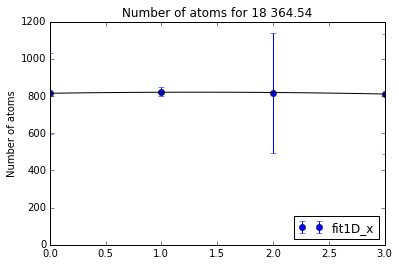

In [32]:
fig3, ax3 = subplots()
ax3.errorbar(**d4)
ax1.set_xlabel('time of flight, ms')
ax3.set_ylabel('Number of atoms')
ax3.set_title('Number of atoms for ' + folder)
ax3.set_ylim(bottom=0)
ax3.legend(loc=4)
fit_func = cloud_drop
popt, pcov = curve_fit(fit_func, d4['x'], d4['y'], p0=(d4['y'][0],0,10))
ax3.plot(linspace(min(d4['x']),max(d4['x']),100), fit_func(linspace(min(d4['x']),max(d4['x']),100),*popt),'k', label='fit Y')
print(popt)

###Plot of each image - to check if everything is ok 

(0, 30.0)

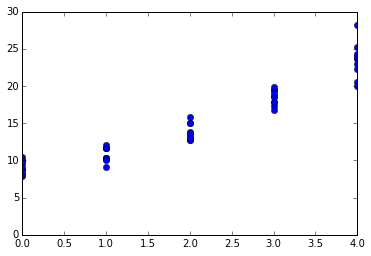

In [33]:
# for each picture
d3 = dict()
d3['x'],d3['y'] = impr.constract_data(dataD, shot_typeN, 'fit1D_x',2)

fig2, ax2 = subplots()
ax2.errorbar(fmt='o',**d3)
ax2.set_ylim(bottom=0)

####Save plots to folder 'Figures' (if in outter directory) and data to file 'all_N_atoms_data.txt' 

In [34]:
if folder != '':
    fig1.savefig(os.path.join('Figures',folder.rstrip(r'\/ ')+'--tempearture.png'))
    # if one need to save atom nubmer:
    #fig3.savefig(os.path.join('Figures',folder.rstrip(r'\/ ')+'--N_atoms.png'))
    try:
        with open('all_temperature_data.txt', 'rb') as handle:
            res_dict = pickle.loads(handle.read())
    except FileNotFoundError:
        res_dict = {}
    except EOFError:
        res_dict = {}
    descript = 'Description: [0],[1] - x,y data for Tx, [2],[3] - x,y data for Ty, [4],[5] - ' + ' fit to this data'
    res_dict[folder.rstrip(r'\/ ')]=(d1['x'], d1['y'],d2['x'], d2['y'],popt_T,popt_T2,descript)
    with open('all_temperature_data.txt', 'wb') as handle:
        pickle.dump(res_dict, handle)
    print('Figure and data saved!!!')

Figure and data saved!!!


####Normalize average data

In [35]:
#norm_avr_dataD = normalise_avr_image(avr_dataD, 1, 2, 'x_data_fit',0)

####Normalize each image

In [36]:
#norm_dataD = normalise_individual_image(dataD, 1, 2, 'x_data_fit',0)


####And do smth with this data

####Looking at second shot_typeN

#x_data,y_data = constract_data(avr_dataD, 2, 'total')
#plot(append(x_data, 0), append(y_data,0), 'o')